# Fitting Analysis, post FFTS


To begin we need to load in the data that we want to fit. Load in all of the FFTs for the condition that will be analyzed. We will then average the ROIs for the condition and then find the diffusion coefficient for each of the averaged ROI regions.


In [34]:
#Import all of the necessary packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.html.widgets import interact, fixed
import ipywidgets as widgets

import io

font_plt = {'family': 'serif',
            'color':  'darkred',
            'weight': 'normal',
            'size': 10,
            }
font_plt_ax = {'family': 'serif',
               'color':  'black',
               'weight': 'normal',
               'size': 10,
              }
import sys
import glob #glob is helpful for searching for filenames or directories
import ddm_clean as ddm #this is the module containing the differential dynamic microscopy code
import scipy #scientific python
from scipy.signal import blackmanharris as bh #for Blackman-Harris windowing
import pickle #for saving data

import mpld3

In [21]:
newt = lambda t,s: (1./s)*gamma(1./s)*t
framerate = 29.0
px = 0.189
imDimension = 128

In [22]:
# You only need to initialize this once for the condition (you will pickle dump it at the end) 
AvgROIs = {}

In [23]:
# different ROIs and the video number, change samNumber based upon the number of videos taken for the condition
con = ['0', '128', '256', '384', '512', '640', '768', '896']
samNumber = ['1','2','3','4','5','6','7','8']
Sample = ['11.6uMact_monomers_0.02mgml', ]
num = 0

In [24]:
# only need to do once for every ROI
ravROI = np.zeros((len(samNumber), 400, 63))

In [25]:
# Change the directory or data file and change the condition number so the average ROI list can be iterated over
data_dir = "Z:\\2018-05-29_DNA_data-to-use\\"+Sample[num]+"_29fps_34exp_1\\"
data_file = Sample[num]+"_29fps_34exp_1_MMStack_Pos0.ome_384_BH_128x128_FFTDIFFS_dts_ravs.p"
dat = pickle.load(open(data_dir + data_file,'r'))
ravs = dat['ravs'] 
dts  = dat['dts']

In [26]:
# This puts the ravs into the average, run this for each different data file you upload 
ravROI[0,:,:] = ravs[:,:]

In [27]:
# Average the radial averages for the ROI for the different videos, then the analysis actually begins 
ravavg = np.average(ravROI, axis=0)

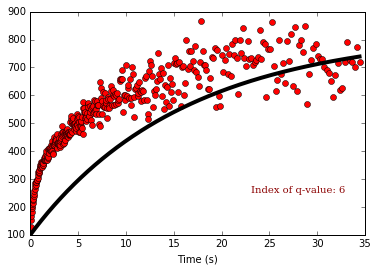

In [35]:
%matplotlib inline
mpld3.enable_notebook()

q = np.arange(0,imDimension/2)*2*np.pi*(1./(imDimension*px*2))
times = dts/framerate
q_index = 6

#We try to use the function `returnReasonableParams` to find reasonable initial guesses for the fitting function

pars,minp,maxp,lmin,lmax,fix = ddm.returnReasonableParams(d=ravs[:,q_index], double=False, fps=framerate)
plt.plot(times, ravs[:,q_index],'ro') #plot the data
plt.plot(times, ddm.dTheory(times,*pars), '-k', lw=4) #see how well the initial guess performs
ax = plt.gca()
plt.text(0.8, 0.2, 'Index of q-value: %i' % q_index, horizontalalignment='center', verticalalignment='center', 
           transform=ax.transAxes, fontdict=font_plt)
plt.xlabel('Time (s)');

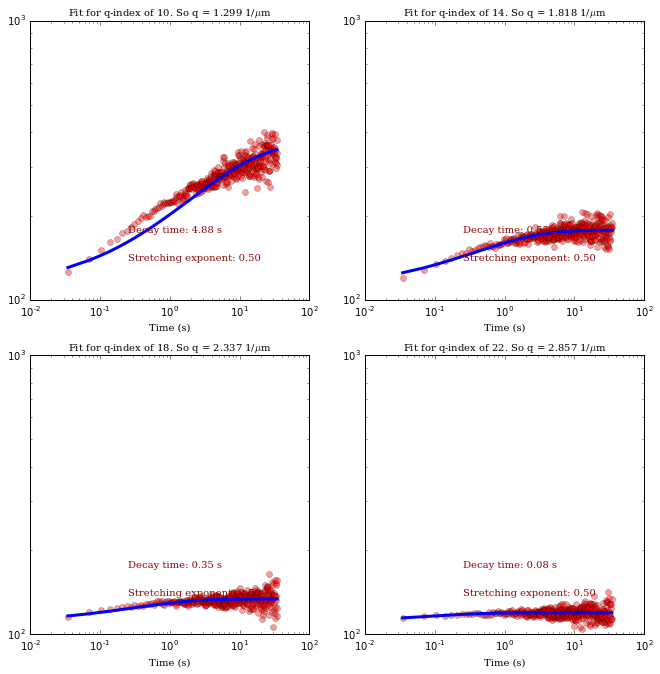

In [43]:
def two_rounds_fitting(data, times):
    '''
    This function does two rounds of fitting. 
    First it uses SciPy's least-squares fitting:
        https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.leastsq.html
    Then, it uses the Levenberg-Marquardt method with the mpfit module. 
    '''
    pars,minp,maxp,lmin,lmax,fix = ddm.returnReasonableParams(d=data, bg=110, double=False, fps=1./times[0])
    #Paramters:
    # Amplitude-0, TimeConst-1, Background-2, Alpha (strtching exp), (... same for second exp..))
    
    minp[3]=0.5
    maxp[3]=1.05
    maxp[2]=1e14
    pars[3]=1.00
    fix[2]=True
    fix[3]=False

    #The ddm.newFitLeastsq function does not check whether the parameters are within the
    #  minimum and maximum bounds. It uses SciPy's optimize.leastsq. 
    fitparams_lsq,theory_lsq = ddm.newFitLeastsq(data,times,pars,minp,maxp,lmin,lmax,fix,logfit=False)
    newPars = fitparams_lsq.copy()
    
    #We'll use the found parameters from SciPy's optimize.leastsq and feed them into the
    #  Levenberg-Marquardt function. Before we do so, we'll check that none of the found
    #  parameters are outside the min/max bounds. 
    for i,p in enumerate(fitparams_lsq):
        if p>maxp[i]:
            newPars[i] = maxp[i]*0.9
        if p<minp[i]:
            if p<0:
                newPars[i]=abs(p)
                if newPars[i]>maxp[i]:
                    newPars[i] = maxp[i]*0.9
                elif newPars[i]<minp[i]:
                    newPars[i] = minp[i]*1.1
            else:
                newPars[i] = minp[i]*1.1
                
    #Now use the Levenberg-Marquardt function. It returns the optimized paramters (fitparamsB), the 
    #  best fit (theoryB), any error codes, and the chi-squared value (the sum of squares of the error)
    fitparamsB, theoryB, errCodeB, chi2B = ddm.newFit(data,times,newPars,minp,maxp,lmin,lmax,fix,
                                                      logfit=False,quiet=True,factor=0.8)
    
    return fitparamsB, theoryB, chi2B

plt.figure(figsize=(11,11)) #Create figure of size 15x15 (inches)

#Loop over four different q-values to do the fit
for i,q_index in enumerate([10,14,18,22]):
    fitparamsB, theoryB, chi2B = two_rounds_fitting(ravs[:,q_index], times)
    ax = plt.subplot(2,2,i+1) #creating 4 subplots in a 2x2 grid
    ax.loglog(times,ravs[:,q_index],'ro',alpha=0.4)
    ax.plot(times, theoryB, '-b',lw=3)
    ax.text(0.35,0.25,'Decay time: %.2f s' % fitparamsB[1], 
            fontdict=font_plt,horizontalalignment='left', 
            verticalalignment='center', transform=ax.transAxes)
    ax.text(0.35,0.15,'Stretching exponent: %.2f' % fitparamsB[3], 
            fontdict=font_plt,horizontalalignment='left', 
            verticalalignment='center', transform=ax.transAxes)
    ax.set_xlabel("Time (s)", fontdict=font_plt_ax)
    ax.set_title("Fit for q-index of %i. So q = %.3f 1/$\mu$m" % (q_index, q[q_index]), fontdict=font_plt_ax)

In [44]:
#Now, we'll do that fit for *all* q-values

#Initialize arrays to store the fit paramters
tau = np.zeros_like(ravs[0,:]) #decay time
amp = np.zeros_like(tau) #amplitude
bg = np.zeros_like(tau) #background
alph = np.zeros_like(tau) #alpha (stretching exponent)
for i in range(1,len(tau)):
    fitparams, theory, chi2 = two_rounds_fitting(ravs[:,i], times)
    amp[i] = fitparams[0]
    bg[i] = fitparams[2]
    tau[i] = fitparams[1]
    alph[i] = fitparams[3]

ddm_clean.py:243: RuntimeWarning: overflow encountered in power
  g1 = np.exp(-1 * (x / t1)**s1)


In [45]:
def DiffCoef (tau, StretchExp, qrange, qmin, qmax):
    nt = ddm.newt(tau, StretchExp)
    indx = (qrange>qmin) & (qrange<qmax)
    ds = (qrange[indx]**-2) / nt[indx]
    return ds.mean()

def Diff_Fit(qrange, taurange, qmin, qmax, StExp, tau):
    step2 = DiffCoef(tau, StExp, qrange, qmin, qmax)
    fit2 = (1./step2) * 1./(qrange**2)
    return fit2, step2
    
#Need to fix the function so the it will fit the data
#define a function to plot the results

def plot_results(alpha=1.8, qmin = q[2], qmax = q[10]):
    qs = q[3:-1]
    taus = tau[2:-1]
    fig,ax = plt.subplots(figsize=(8,8/1.618))
    plt.xlim((0.5,10))
    plt.ylim((0.005,40))
    ax.loglog(qs, tau[2:-1], 'ro')
    ax.loglog(qs, ddm.newt(taus ,alph [2:-1]),'bo')
    fits = Diff_Fit(qs,taus, qmin, qmax, alph[3:], tau[3:])
    ax.plot(qs, fits[0],  '-k')
    ax.text(0.55,0.8,'D = %.2f' % fits[1], 
        fontdict=font_plt,horizontalalignment='left', 
        verticalalignment='center', transform=ax.transAxes)

In [33]:
# Saving the data into the pickle file
AvgROIs['bestfitparms_ROI'+con[0]] = fitparams
AvgROIs['bestfitDiffCoef_ROI'+con[0]] = 0 #enter in the value after fitting the diffusion coefficient

NameError: name 'fitparams' is not defined

In [ ]:
# Do once you have averaged and fit all of the ROIs for the condition 
#pickle.dump(AvgROIs, open('ROIResults_'+Sample[0]+'.p', 'wb'))
#Just seeing what happens if I add something, trying to figure out github